<a href="https://www.kaggle.com/code/jiprud/tps-mar22-rookie-eda-submission?scriptVersionId=91044707" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5) # set default size of figures

# Load Data

In [2]:
train_df = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', index_col = 'time',parse_dates=['time'])
test_df = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col = 'time',parse_dates=['time'])

# Explore

In [3]:
display(train_df.head())
display(test_df.head())

,row_id,x,y,direction,congestion
time,,,,,
1991-04-01,0,0,0,EB,70
1991-04-01,1,0,0,NB,49
1991-04-01,2,0,0,SB,24
1991-04-01,3,0,1,EB,18
1991-04-01,4,0,1,NB,60


,row_id,x,y,direction
time,,,,
1991-09-30 12:00:00,848835,0,0,EB
1991-09-30 12:00:00,848836,0,0,NB
1991-09-30 12:00:00,848837,0,0,SB
1991-09-30 12:00:00,848838,0,1,EB
1991-09-30 12:00:00,848839,0,1,NB


## Roads

x - the east-west midpoint coordinate of the roadway

y - the north-south midpoint coordinate of the roadway

direction - the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel.

lets plot the "map" using x and y coordinates

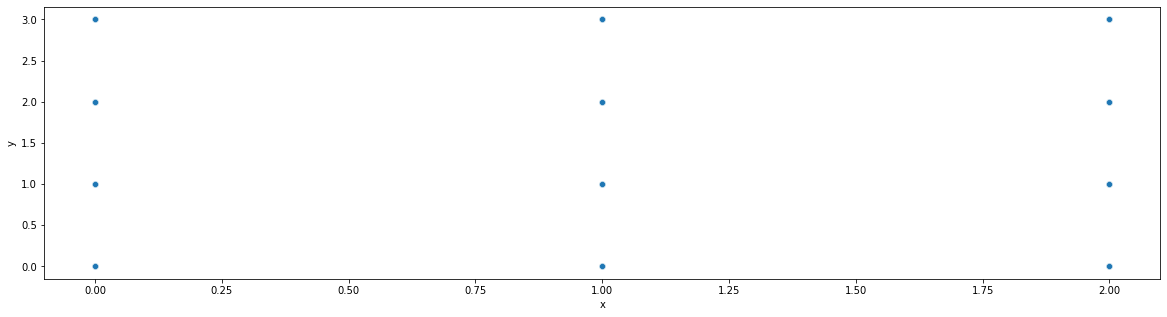

In [4]:
sns.scatterplot(data=train_df, x='x',y='y');

X coordinate has only 3 values, Y coordinage has 4. It means that there are only 12 roadways.

There are 8 possible directions: 'EB', 'NB', 'SB', 'WB', 'NE', 'SW', 'NW', 'SE', but each road doesn't have to go in all directions. Lets calc how many combinations of coordinates and directions is present in the dataset:

In [5]:
len(train_df.groupby(['x','y','direction']))

65

There are 65 different roads in the dataset. 
A road is defined by: coordinates and direction.

## Time

In [6]:
display(train_df.index.min())
display(train_df.index.max())

Timestamp('1991-04-01 00:00:00')

Timestamp('1991-09-30 11:40:00')

Training data contain samples from 1st April 1991 to 30th September 1991. It means 6 months half of the year.

In [7]:
display(test_df.index.min())
display(test_df.index.max())

Timestamp('1991-09-30 12:00:00')

Timestamp('1991-09-30 23:40:00')

Our model will be evaluated by predictions for the half of one day (afternoon of 30th September 1991)

## Congestion (target)

congestion - congestion levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100.

Lets draw congestion over time for few randomly selected roadways.

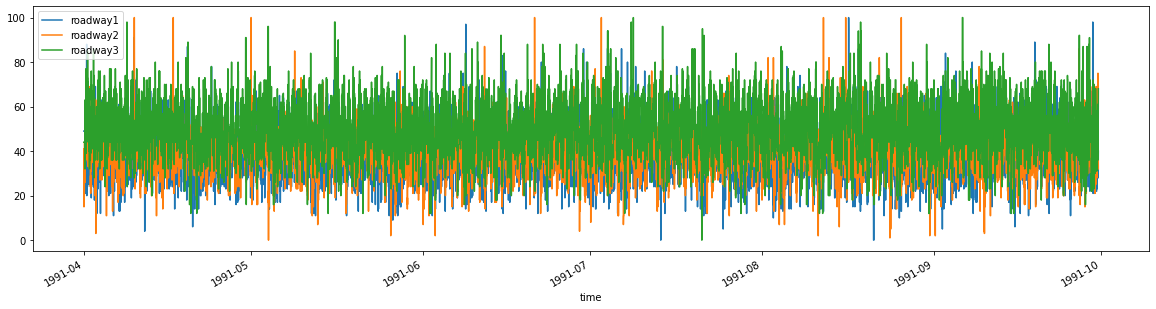

In [8]:
roadway1 = train_df.query("x==0 & y==0 & direction=='NB'")
roadway2 = train_df.query("x==1 & y==3 & direction=='EB'")
roadway3 = train_df.query("x==1 & y==3 & direction=='NE'")

congestion_df = pd.DataFrame()
congestion_df.index = roadway1.index
congestion_df['roadway1'] = roadway1.congestion
congestion_df['roadway2'] = roadway2.congestion
congestion_df['roadway3'] = roadway3.congestion
congestion_df.plot();

In [9]:
congestion_df

,roadway1,roadway2,roadway3
time,,,
1991-04-01 00:00:00,49,41,44
1991-04-01 00:20:00,49,16,44
1991-04-01 00:40:00,49,15,44
1991-04-01 01:00:00,49,15,44
1991-04-01 01:20:00,49,20,44
...,...,...,...
1991-09-30 10:20:00,29,56,36
1991-09-30 10:40:00,28,37,55
1991-09-30 11:00:00,31,42,46


The plot is a bit unclear for human eye. Lets zoom in and display only one (randomly selected) day.

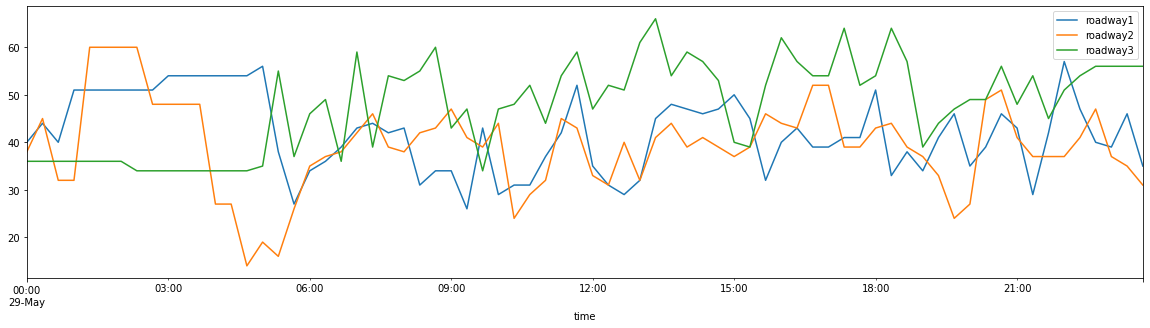

In [10]:
congestion_df['1991-05-29 00:00:00':'1991-05-29 23:40:00'].plot();

An interesting infromation may be to see the congestion for one roadway, but in all possible directions.

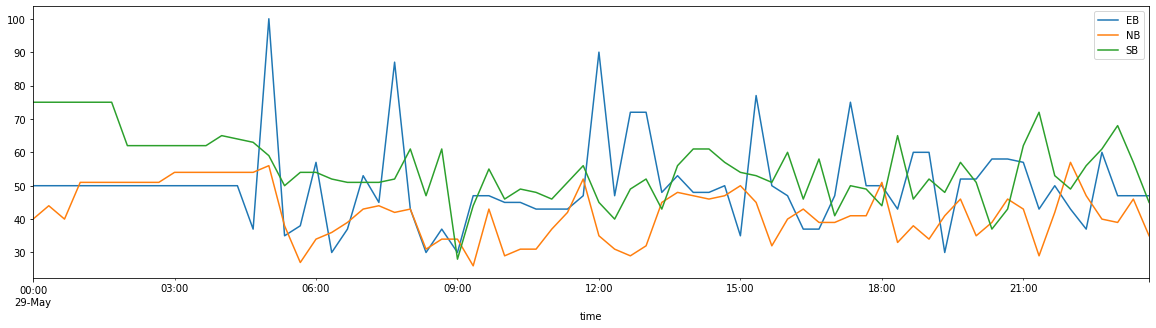

In [11]:
# Roadway x=0, y=0 has these three direction: EB NB SB
roadway00_EB = train_df.query("x==0 & y==0 & direction=='EB'").copy()
roadway00_NB = train_df.query("x==0 & y==0 & direction=='NB'").copy()
roadway00_SB = train_df.query("x==0 & y==0 & direction=='SB'").copy()


congestion_df = pd.DataFrame()
congestion_df.index = roadway00_EB.index
congestion_df['EB'] = roadway00_EB.congestion
congestion_df['NB'] = roadway00_NB.congestion
congestion_df['SB'] = roadway00_SB.congestion

congestion_df['1991-05-29 00:00:00':'1991-05-29 23:40:00'].plot();

Now let's agreggate congestion for one road in one direction for all measured days.
Note: following graphs are inspired by Kaggle Time Series tutorial: https://www.kaggle.com/code/ryanholbrook/seasonality/tutorial

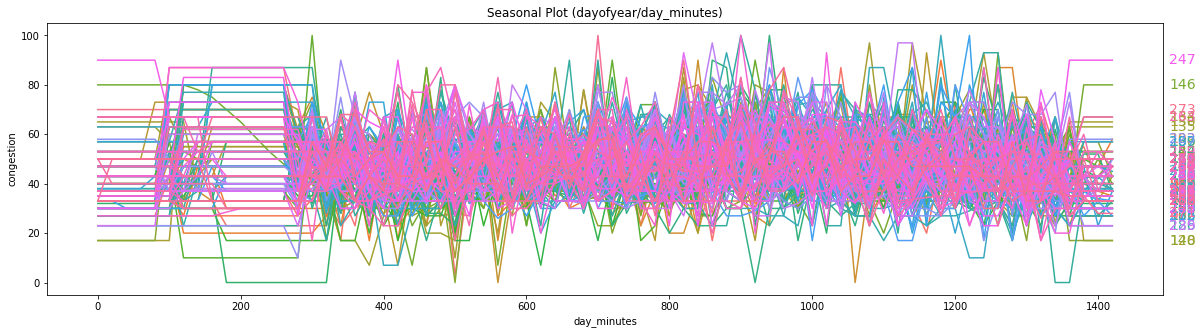

In [12]:
from learntools.time_series.utils import seasonal_plot

roadway00_EB["dayofyear"] = roadway00_EB.index.dayofyear
roadway00_EB["day_minutes"] = roadway00_EB.index.hour * 60 + roadway00_EB.index.minute

seasonal_plot(roadway00_EB, y="congestion", period="dayofyear", freq="day_minutes");

The graph for all days is a bit messy. Let's plot only Mondays as it is our target day for prediction.

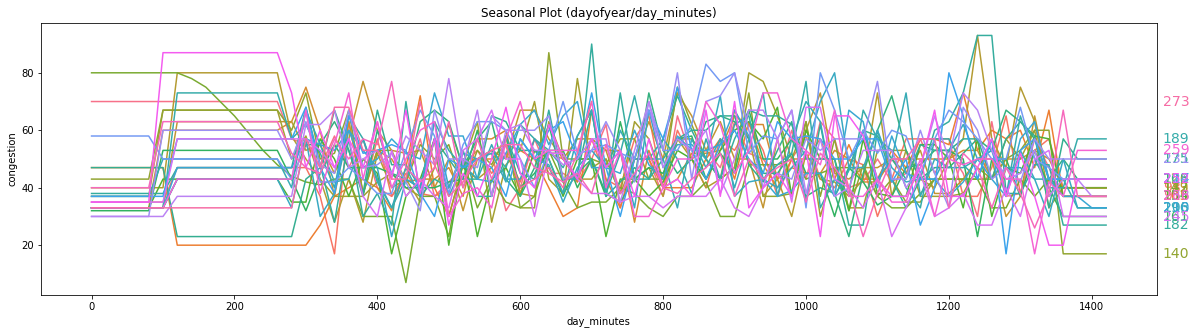

In [13]:
roadway00_EB['dayofweek'] = roadway00_EB.index.dayofweek

seasonal_plot(roadway00_EB[roadway00_EB.dayofweek == 0], y="congestion", period="dayofyear", freq="day_minutes");


## Model

At the beginning I will just try if I am able to generate a meaningful submission file. Let's use just mean value as target for now.

In [14]:
mean = train_df.congestion.mean()

test_df['congestion'] = mean

### Save into submission file

In [15]:
test_df.to_csv('submission.csv',columns=['row_id','congestion'],index=False)

To be continued...